In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import random
from sklearn.neighbors import KernelDensity,BallTree
from sklearn.preprocessing import MinMaxScaler
import cPickle as pkl
#from sklearn.cross_validation import train_test_split

In [2]:
train = pd.read_hdf('cross_validation.h5','train') 
test = pd.read_hdf('cross_validation.h5','test')
group1_2 = pd.read_hdf('storage_group.h5','group1_2')
group3 = pd.read_hdf('storage_group.h5','group3')
group_all = train.groupby('place_id')
#del train

In [10]:
pop_last_months = train_2.groupby('place_id').agg({'place_id':'count'})
pop_last_months.columns = ['checkins_90']
pop_last_months['popularity_90'] = pop_last_months.checkins_90/90.

In [ ]:
group1 = train.groupby('place_id').agg({'place_id':'count','day':{'last_check_in':'max','first_check_in':'min'},
                                       'x':{'x_med':'median'},'y':{'y_med':'median'}})

group1.columns = group1.columns.droplevel(0)

group1['popularity'] = group1['count']*1./(group1.last_check_in+1 - group1.first_check_in)
group1.head()

group1['duration'] = (group1.last_check_in+1 - group1.first_check_in)

#group1.reset_index(inplace=1)

In [ ]:
group1_2 = group1.merge(pop_last_months,how='left',left_index=1,right_index=1)
group1_2.fillna(value=-1,inplace=1,axis=1)

In [ ]:
scale_features = ['count','last_check_in','first_check_in','duration','checkins_90']
group1_2[scale_features] = MinMaxScaler(feature_range=(0.01,1.01)).fit_transform(group1_2[scale_features])

In [ ]:
ttl_cols = scale_features + ['popularity','popularity_90']
group1_2['ttl_col'] = group1_2[ttl_cols].product(axis=1)
#del group1

In [22]:
pop_last_months.ix[13789]

checkins_90      15.000000
popularity_90     0.166667
Name: 13789, dtype: float64

In [5]:
group1_2.head()

,place_id,y_med,x_med,count,last_check_in,first_check_in,popularity,duration,checkins_90,popularity_90,ttl_col
0,0,5.54945,2.6915,0.050584,0.972,0.032,0.161359,0.950,0.013652,0.044444,1.463432e-07
1,1,4.34700,7.1079,0.058701,0.986,0.036,0.191176,0.960,0.015844,0.077778,4.712425e-07
2,2,5.56990,0.9824,0.293550,1.010,0.026,1.064909,0.994,0.078663,1.033333,6.632658e-04
3,3,5.83405,2.8068,0.473745,1.010,0.014,1.719439,1.006,0.128335,1.788889,2.660145e-03
4,4,7.55050,3.9737,0.028398,1.006,0.162,0.082742,0.854,0.022418,0.177778,1.303351e-06


In [80]:
group1_2[group1_2.place_id==13789]

,place_id,y_med,x_med,count,last_check_in,first_check_in,popularity,duration,checkins_90,popularity_90,ttl_col
13647,13789,3.2179,3.2036,0.047879,1.008,0.044,0.146998,0.974,0.021687,0.166667,0.000001


In [3]:
ball_tree = BallTree(group1_2[['x_med','y_med']],metric = 'manhattan')

In [ ]:
group1_2.to_hdf('storage_group.h5','group1_2')

In [12]:
def computeKDE(place_ids):
#def computeKDE():
    #place_ids = group_all.groups.keys()
    kde_day_hr = {}
    kde_default = KernelDensity(kernel='gaussian',bandwidth=0.25)
    kde_params = kde_default.get_params()
    for place_id in place_ids:
        kde_temp = {}
        data = group_all.get_group(place_id)
        data_1 = data.groupby(['7day'])['24hr']
        data_1.columns = ['24hr_count']
        for day in data_1.groups.keys():
            data_2 = data_1.get_group(day)
            kde_temp[day] = KernelDensity(**kde_params)
            kde_temp[day] = kde_temp[day].fit(data_2.reshape(-1,1))
        kde_day_hr[place_id] = kde_temp
        
    return kde_day_hr
    

In [ ]:
kde_day_hr = computeKDE()

In [48]:
data_test = group_all.get_group(13789)

In [49]:
data_1 = data_test.groupby(['7day'])['24hr']
data_1.columns = ['24hr_count']

In [50]:
data_1.groups.keys()

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [15]:
data_2 = data_1.get_group(0)

In [31]:
kde_day_hr = {}
kde_temp = {}
for day in data_1.groups.keys():
    data_2 = data_1.get_group(day)
    kde_default = KernelDensity(kernel='gaussian',bandwidth=0.25)
    kde_temp[day] = kde_default.fit(data_2.reshape(-1,1))
kde_day_hr[13789] = kde_temp 

In [33]:
another_kde = kde_day_hr[13789]

In [40]:
np.exp(another_kde[6.0].score(22))

0.00010706418061190825

In [17]:
kde_default = KernelDensity(kernel='gaussian',bandwidth=0.25)

In [20]:
kde_default.fit(data_2.reshape(-1,1))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.25, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [25]:
data_2.reshape(-1,1)

array([[  2.],
       [ 22.],
       [ 20.],
       [ 19.],
       [  4.],
       [ 20.],
       [  4.]])

In [26]:
np.exp(kde_default.score(22))

0.22796701737225303

In [9]:
data_1.reset_index(level=1,inplace=1)

In [11]:
data_1.ix[0]

,24hr,24hr_count
7day,,
0,2,1
0,4,2
0,19,1
0,20,2
0,22,1


In [5]:
def reducedBT(data_BT_ind,y,y_std):
    above = group1_2.y_med.ix[data_BT_ind] <= y + y_std
    below = group1_2.y_med.ix[data_BT_ind] >= y - y_std
    both = above & below
    ind_both = both.index[np.where(both)].values
    
    return ind_both

In [6]:
def reducedBTHelper(ind):
    acc = int(test.ix[ind].accuracy)
    y_std = 2 * group3.ix[acc].y
    r = 1 * group3.ix[acc].x
    y = test.ix[ind].y
    test_BT_ind = ball_tree.query_radius(test[['x','y']].ix[ind].reshape(1,-1),r=r,return_distance=0)
    ind_both = reducedBT(test_BT_ind[0],y,y_std)
    
    return ind_both
    #return test_BT_ind,r,y_std,y

In [58]:
def calculateProbKde(place_ids,kde,val):
    prob = np.empty((0,0))
    for place_id in place_ids:
        kde_place_id = kde[place_id]
        prob = np.append(prob,np.exp(kde_place_id.score(val)))
    return prob

In [55]:
def score2(data,place_ids):
    scores = pd.DataFrame(columns=['prob_hr','prob_day','prob_week','prob_month'],index=place_ids)
    kde_hr_score = calculateProbKde(place_ids,kde_hr,data['24hr'].reshape(-1,1))
    kde_day_score = calculateProbKde(place_ids,kde_day,data['7day'].reshape(-1,1))
    kde_week_score = calculateProbKde(place_ids,kde_week,data['week'].reshape(-1,1))
    kde_month_score = calculateProbKde(place_ids,kde_month,data['month'].reshape(-1,1))
    scores['prob_hr'] = kde_hr_score
    scores['prob_day'] = kde_day_score
    scores['prob_week'] = kde_week_score
    scores['prob_month'] = kde_month_score
    #scores['ttl'] = scores[['prob_hr','prob_week','prob_month']].sum(axis=1)
    #scores['ttl'] = scores.sum(axis=1)
    scores['ttl'] = scores.product(axis=1)
    
    return scores['ttl']

In [56]:
#def score1(place_ids_ind):
def score1(place_ids):
    #scores = group1_2['ttl_col'].ix[place_ids_ind]
    scores = group1_3['ttl_col'].ix[place_ids]
    return scores

In [36]:
def ensembleScores(score_1,score_2):
    combined_scores = pd.concat((score_1,score_2),axis=1,join='inner').sum(axis=1)
    #combined_scores = pd.concat((score_1,score_2),axis=1,join='inner').product(axis=1)
    combined_scores = combined_scores.sort_values(ascending=0)
    #top3 = combined_scores.index[:3]
    #top3_string = [' '.join(top3.astype(str))]
    top3 = combined_scores.index[:5].values
    return top3
    #return combined_scores
    #return top3_string

In [170]:
n = 1
submission = pd.DataFrame(columns = ['place_id'],index = test.index[:n])

for ind in test.index[:n]:
    #if ind%10 == 0:
    #    print ind,
    row = test.ix[ind]
    topNN_ind = reducedBTHelper(ind)
    place_ids = group1_2.ix[topNN_ind].place_id
    score_2 = score2(row,place_ids)
    score_2_sort = score_2.sort_values(ascending=0)
    #print len(place_ids),
    #submission.ix[ind] = [list(score_2_sort.index.values[:25])]
    top20 = score_2_sort[:20].index.values
    score_1 = score1(top20)
    #submisson.iloc[i] = ensembleScores(score_1,score_2,score_3)
    #submission.ix[ind] = [list(ensembleScores(score_1,score_2))]
    #submission.ix[ind] = [list(score_2.sort_values(ascending=0)[:3].index.values)]
    submission.ix[ind] = [list(score_1.sort_values(ascending=0)[:3].index.values)]

In [83]:
group1_3 = group1_2.copy()
group1_3.index = group1_2.place_id

In [13]:
ind = 16
row = test.ix[ind]
topNN_ind = reducedBTHelper(ind)
place_ids = group1_2.ix[topNN_ind].place_id
kde_day_hr = computeKDE(place_ids)
#score_2 = score2(row,place_ids)
#score_2_sort = score_2.sort_values(ascending=0)

In [15]:
row['24']

x               3.2494
y               3.2096
accuracy       75.0000
day           540.0000
24hr            6.0000
7day            1.0000
week           25.0000
month           6.0000
place_id    13789.0000
Name: 16, dtype: float64

In [23]:
prob = []
for place_id in place_ids:
    temp_kde = kde_day_hr[place_id]
    try:
        temp_kde_day = temp_kde[row['7day']]
        temp = np.exp(temp_kde_day.score(row['24hr']))
    except KeyError:
        temp = 0.0
    prob.append((place_id,temp))

In [28]:
sorted(prob,key=lambda x:x[1],reverse=1)

[(48393, 0.58032834612055095),
 (57953, 0.4296713266556268),
 (55592, 0.28170078397214182),
 (47660, 0.28163780504237013),
 (78067, 0.13311459035958081),
 (40167, 0.1139835086861251),
 (1277, 0.11059985939649003),
 (68283, 0.10642029616725537),
 (59923, 0.093884516591604142),
 (94479, 0.084049833031185184),
 (60984, 0.029062649565838729),
 (45797, 0.024591472709555535),
 (57070, 0.023530171894563051),
 (101558, 8.2357062009160174e-05),
 (13789, 5.0522710835368856e-15),
 (40639, 2.5261355417684381e-15),
 (41222, 3.9625545889163721e-32),
 (73485, 1.9078966539227239e-32),
 (106641, 2.7604741810798533e-88),
 (50752, 2.2775774787367285e-172),
 (95140, 0.0)]

In [65]:
data_test = group_all.get_group(50752)

data_test_group = data_test.groupby('7day')['24hr']

print data_test.x.std(),data_test.x.median()

0.759585952859 3.13885


In [45]:
data_test_group.get_group(1)

496011       6
1416621      5
5402745      6
7261512      6
10023583     4
10745684     8
11108147     6
16372709     8
20454544    22
23360864     8
23513115     3
Name: 24hr, dtype: float64

In [59]:
data_test = group_all.get_group(13789)

#data_test_group = data_test.groupby('7day')['24hr']

print data_test.x.std(),data_test.x.median()

0.758215317764 3.2036


In [57]:
data_test.x.median()

3.2036

In [20]:
kde_day_hr[95140]

{0.0: KernelDensity(algorithm='auto', atol=0, bandwidth=0.25, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 3.0: KernelDensity(algorithm='auto', atol=0, bandwidth=0.25, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 4.0: KernelDensity(algorithm='auto', atol=0, bandwidth=0.25, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 5.0: KernelDensity(algorithm='auto', atol=0, bandwidth=0.25, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 6.0: KernelDensity(algorithm='auto', atol=0, bandwidth=0.25, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0)}

In [104]:
top20 = score_2_sort[:10].index.values
score_1 = score1(top20)

In [105]:
top20

array([68283, 60984,  1277, 94479, 40167, 78067, 47660, 48393, 45797, 13789], dtype=int64)

In [101]:
score_1.sort_values(ascending=0)

place_id
94479     4.302285
1277      1.937639
45797     1.639067
60984     1.253166
57070     1.230342
57953     0.682568
47660     0.302311
48393     0.199229
41222     0.158704
59923     0.091505
78067     0.078688
73485     0.076540
40639     0.050839
13789     0.024054
101558    0.023836
55592     0.023258
40167     0.017962
68283     0.006121
50752     0.003152
95140     0.000735
Name: ttl_col, dtype: float64

In [91]:
group3.ix[75]

y    0.011828
x    0.246849
Name: 75, dtype: float64

In [89]:
test.ix[16]

x               3.2494
y               3.2096
accuracy       75.0000
day           540.0000
24hr            6.0000
7day            1.0000
week           25.0000
month           6.0000
place_id    13789.0000
Name: 16, dtype: float64

In [94]:
group1_3 = group1_3.drop(['count','first_check_in','checkins_90'],axis=1)

In [96]:
ttl_cols = ['popularity','popularity_90','last_check_in','duration']
group1_3['ttl_col'] = group1_3[ttl_cols].product(axis=1)

In [106]:
group1_3.ix[top20].sort_values('ttl_col',ascending=0)

,place_id,y_med,x_med,last_check_in,popularity,duration,popularity_90,ttl_col
place_id,,,,,,,,
94479,94479,3.2156,3.4307,1.004,3.283133,1.004,1.300000,4.302285
1277,1277,3.2055,3.4156,1.010,1.468354,0.956,1.366667,1.937639
45797,45797,3.2039,3.4697,1.010,1.180361,1.006,1.366667,1.639067
60984,60984,3.2161,3.2793,1.008,1.112224,1.006,1.111111,1.253166
47660,47660,3.2126,3.0882,1.002,0.523232,0.998,0.577778,0.302311
48393,48393,3.2301,3.1906,1.008,0.348790,1.000,0.566667,0.199229
78067,78067,3.2026,3.4178,0.986,0.281314,0.982,0.288889,0.078688
13789,13789,3.2179,3.2036,1.008,0.146998,0.974,0.166667,0.024054
40167,40167,3.2316,3.0487,0.988,0.203008,0.806,0.111111,0.017962


In [196]:
data = group_all.get_group(idx)
data[data.accuracy==76]

,x,y,accuracy,day,24hr,7day,week,month,place_id
16537148,0.5042,3.2041,76,212,10,2,30,6,68283
23068869,3.2996,3.1927,76,216,11,6,30,7,68283


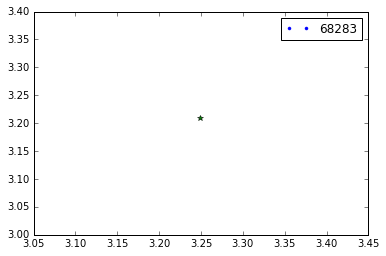

In [188]:
for idx in top20[:1]:
    data = group_all.get_group(idx)[['x','y','accuracy']]
    data = data[data.accuracy==75][['x','y']]
    plt.plot(data.x,data.y,'.',label=idx)
plt.legend()    
plt.plot(row.x,row.y,'*')        

(0, 10)

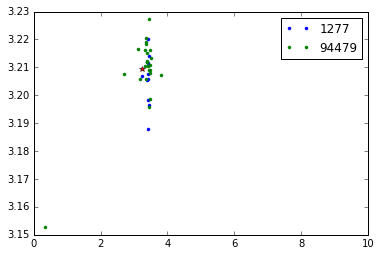

In [186]:
for idx in top20[2:4]:
    data = group_all.get_group(idx)[['x','y','accuracy']]
    data = data[data.accuracy==75][['x','y']]
    plt.plot(data.x,data.y,'.',label=idx)
plt.legend()    
plt.plot(row.x,row.y,'*')   
plt.xlim(0,10)

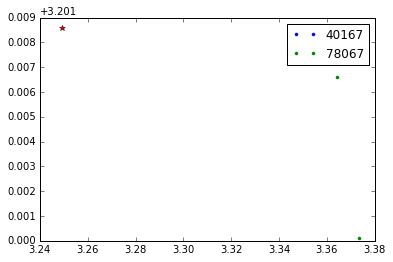

In [184]:
for idx in top20[4:6]:
    data = group_all.get_group(idx)[['x','y','accuracy']]
    data = data[data.accuracy==75][['x','y']]
    plt.plot(data.x,data.y,'.',label=idx)
plt.legend()
plt.plot(row.x,row.y,'*')      

(3.05, 4)

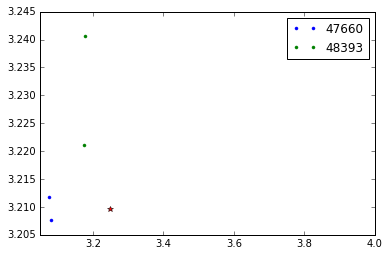

In [183]:
for idx in top20[6:8]:
    data = group_all.get_group(idx)[['x','y','accuracy']]
    data = data[data.accuracy==75][['x','y']]
    plt.plot(data.x,data.y,'.',label=idx)
plt.legend()
plt.plot(row.x,row.y,'*')  
plt.xlim(3.05,4)

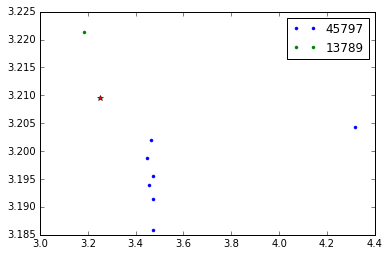

In [181]:
for idx in top20[8:]:
    data = group_all.get_group(idx)[['x','y','accuracy']]
    data = data[data.accuracy==75][['x','y']]
    plt.plot(data.x,data.y,'.',label=idx)
plt.legend()
plt.plot(row.x,row.y,'*')      

In [107]:
#GMM

from sklearn.mixture import GMM

In [169]:
num_c = 2
clf = GMM(n_components=num_c,covariance_type='tied')

In [173]:
data1_1 = group_all.get_group(45797)[['x','y','accuracy']]
data1_2 = group_all.get_group(13789)[['x','y','accuracy']]
data1_2_all = pd.concat((data1_2,data1_1),axis=0)

In [178]:
data1_2[data1_2.accuracy==75]

,x,y,accuracy
3022316,3.184,3.2214,75


In [179]:
data1_1[data1_1.accuracy==75]

,x,y,accuracy
5977028,3.4655,3.2019,75
10907354,3.4483,3.1987,75
16357199,4.3163,3.2043,75
21033227,3.4711,3.1956,75
26680952,3.4718,3.1915,75
27228677,3.4746,3.1858,75
28547375,3.4575,3.1940,75


In [180]:
row

x               3.2494
y               3.2096
accuracy       75.0000
day           540.0000
24hr            6.0000
7day            1.0000
week           25.0000
month           6.0000
place_id    13789.0000
Name: 16, dtype: float64

In [170]:
clf.fit(data1_2_all)

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [171]:
clf.predict_proba(row[['x','y']].reshape(1,-1))

array([[  1.00000000e+00,   6.17376768e-43]])

In [172]:
clf.means_

array([[ 3.44810767,  3.20383997],
       [ 7.19345768,  3.21928572]])

In [154]:
clf.predict(row[['x','y']].reshape(1,-1))

array([0], dtype=int64)

In [158]:
clf.predict_proba(data1_2_all)

array([[ 0.97825242,  0.02174758],
       [ 0.98024799,  0.01975201],
       [ 0.95406027,  0.04593973],
       ..., 
       [ 0.99832702,  0.00167298],
       [ 0.99853142,  0.00146858],
       [ 0.99861683,  0.00138317]])

In [145]:
ttl_true = 0
for ind in test.index[:n]:
    actual_id = test.ix[ind].place_id
    if actual_id in submission.ix[ind].place_id:
        ttl_true += 1
print ttl_true*1./n        

0.18


In [63]:
import ml_metrics as metrics
target = [[tar] for tar in test[:n].place_id]

metrics.mapk(target,submission.place_id,k=3)

0.14749999999999999

In [281]:
data = group_all.get_group(94479)

data_1 = data[(data.day>=410) & (data.day<=500)]

In [247]:
data.head()

,x,y,accuracy,day,24hr,7day,week,month,place_id
6559,3.3455,3.2195,51,44,14,2,6,1,94479
51135,1.5778,3.1329,74,279,16,6,39,9,94479
64839,3.3623,3.2147,975,344,17,1,49,11,94479
72980,3.4518,3.2193,65,89,10,5,12,2,94479
115120,3.1875,3.2119,1,96,8,5,13,3,94479


In [282]:
data_2 = data.groupby(['month','week','7day','24hr']).agg({'24hr':'count'})
#plt.plot(data_2['24hr'],'*-')

In [285]:
data_2.ix[6].ix[25]

,,24hr
7day,24hr,


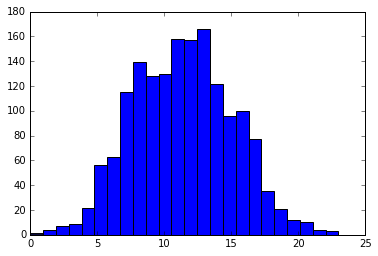

In [250]:
_=plt.hist(data['24hr'],bins=24)

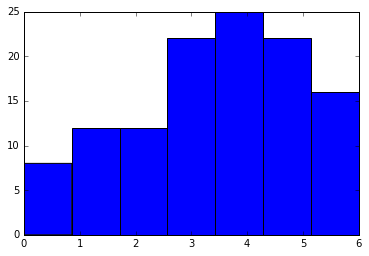

In [213]:
_=plt.hist(data_1['7day'],bins=7)

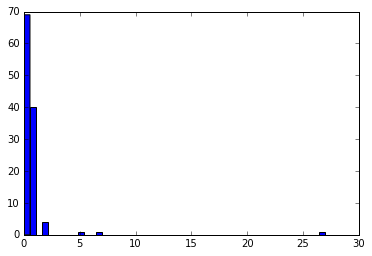

In [245]:
_=plt.hist(data_1.day.sort_values().diff().dropna(),bins=50)

In [204]:
row

x               3.2494
y               3.2096
accuracy       75.0000
day           540.0000
24hr            6.0000
7day            1.0000
week           25.0000
month           6.0000
place_id    13789.0000
Name: 16, dtype: float64

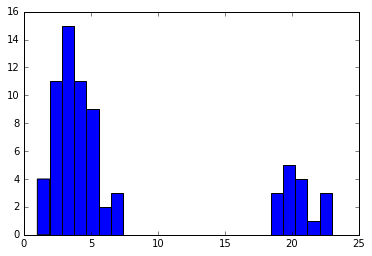

In [290]:
data = group_all.get_group(13789)

data_1 = data[(data.day>=410) & (data.day<=500)]
_=plt.hist(data['24hr'],bins=24)

In [242]:
data.head()

,x,y,accuracy,day,24hr,7day,week,month,place_id
139028,3.2061,3.2169,65,367,3,3,0,1,13789
219511,3.2099,3.2172,71,479,4,3,16,4,13789
1784089,3.1852,3.2027,158,122,5,3,17,4,13789
1852548,3.2296,3.2330,17,129,3,3,18,4,13789
3022316,3.1840,3.2214,75,214,20,4,30,7,13789


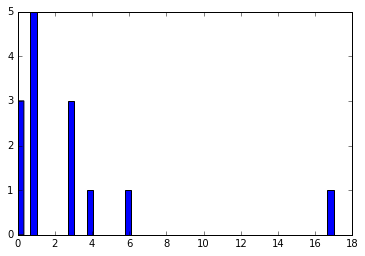

In [243]:
_=plt.hist(data_1.day.sort_values().diff().dropna(),bins=50)

In [253]:
data.head()

,x,y,accuracy,day,24hr,7day,week,month,place_id
139028,3.2061,3.2169,65,367,3,3,0,1,13789
219511,3.2099,3.2172,71,479,4,3,16,4,13789
1784089,3.1852,3.2027,158,122,5,3,17,4,13789
1852548,3.2296,3.2330,17,129,3,3,18,4,13789
3022316,3.1840,3.2214,75,214,20,4,30,7,13789


In [298]:
data_2 = data.groupby(['month','7day','24hr']).agg({'24hr':'count'})

In [299]:
data_2

24hr
month 7day 24hr      
0     3    3        1
           4        1
1     3    3        2
           5        2
           20       1
      4    4        1
2     0    2        1
      2    21       1
      3    3        1
           4        1
           5        2
      4    3        1
3     0    22       1
      1    1        1
           4        1
           19       1
      2    3        1
      3    5        1
           7        1
4     0    20       1
      2    3        1
           19       1
           21       1
           23       1
      3    2        4
           3        5
           4        1
           5        2
           6        2
      6    2        1
           4        1
5     1    2        1
      2    4        1
           21       1
      3    1        1
           3        1
           7        2
      4    2        1
           4        1
      6    1        2
6     0    4        2
           19       1
      3    2        2
      5    23       1
      6    21       1
7     0    20       1
      2    4        1
           20       1
      3    3        1
      4    20       1
8     3    3        1
      4    5        1
9     3    5        1
10    2    23       1
11    3    2        1

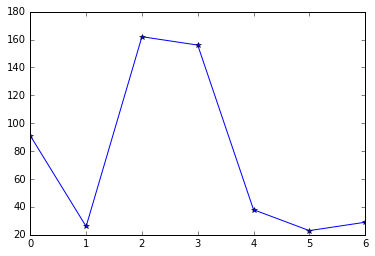

In [260]:
plt.plot(data_2['24hr'],'*-')